In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lib.occupancy import compute_occupancy, estimate_rate_occupancy

# Paths
fails_path_run3 = "1_data/df3_valid.csv"
beam_path_run3 = "1_data/beam3.csv"
fails_path_run2 = "1_data/df2_valid.csv"
beam_path_run2 = "1_data/beam2.csv"

def load_and_prep_data(fails_path, beam_path):
    print(f"Loading {fails_path} and {beam_path}...")
    fails = pd.read_csv(fails_path)
    beam = pd.read_csv(beam_path)
    
    # Convert time columns
    fails['time'] = pd.to_datetime(fails['time'])
    beam['time'] = pd.to_datetime(beam['time'])
    
    # Sort
    fails = fails.sort_values('time')
    beam = beam.sort_values('time')
    
    # Ensure beam_on is boolean
    beam['beam_on'] = beam['beam_on'].astype(bool)
    
    return fails, beam

# both runs
fails_2, beam_2 = load_and_prep_data(fails_path_run2, beam_path_run2)
print(f"Loaded {len(fails_2)} fails and {len(beam_2)} beam records.")

fails_3, beam_3 = load_and_prep_data(fails_path_run3, beam_path_run3)
print(f"Loaded {len(fails_3)} fails and {len(beam_3)} beam records.")

# --- merging ---

# Merge fails with beam data (backward search to find the latest beam status)
fails_merged_2 = pd.merge_asof(fails_2, beam_2, on='time', direction='backward')
fails_merged_3 = pd.merge_asof(fails_3, beam_3, on='time', direction='backward')

# Filter for Beam ON
fails_on_2 = fails_merged_2[fails_merged_2['beam_on'] == True].copy()
fails_on_3 = fails_merged_3[fails_merged_3['beam_on'] == True].copy()

print(f"Fails total: {len(fails_2)}")
print(f"Fails total: {len(fails_3)}")
print(f"Fails with Beam ON: {len(fails_on_2)}")
print(f"Fails with Beam ON: {len(fails_on_3)}")


Loading 1_data/df2_valid.csv and 1_data/beam2.csv...
Loaded 1030123 fails and 9999 beam records.
Loading 1_data/df3_valid.csv and 1_data/beam3.csv...
Loaded 1081006 fails and 9997 beam records.
Fails total: 1030123
Fails total: 1081006
Fails with Beam ON: 745684
Fails with Beam ON: 1070425


In [2]:
fails_on_2.head(
)

,Unnamed: 0_x,time,lfsrTMR,B0,B1,B2,B3,fails_inst,fails_acum,bitn0,...,N1MeV,run_group,dt,dTID,dHEH,dN1MeV,TID_dose_rate,N1MeV_dose_rate,HEH_dose_rate,beam_on
0,0,2022-09-14 11:35:48.885571,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True
1,1,2022-09-14 11:35:49.306446,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True
2,2,2022-09-14 11:35:49.727205,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True
3,3,2022-09-14 11:35:50.135328,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True
4,4,2022-09-14 11:35:50.556157,0,FF00,FF00,FF00,FF00,0,0,0,...,607606.670655,2,55.08541,5.592353e-07,1310.175985,7352.374067,1.015215e-08,133.472259,23.784447,True


## Types of radiation and errors
Given that in this notebook we will be analyzing the errors produced by radiation, considering bit flips inside a TMR system. We need to consider that we are able to perform analysis of the device on its useful life time.

### Types of radiation
- TID: Ionizing radiation wich causes slowly a permanent change in the device.
- HEH: High energy hadrons wich may cause Single Event Upsets or Latch-Ups
- N1Mev: Considering equivalent of neutrons, may cause damage in the structure of the material inside the chip, also an slow permanent damage.


### Types of errors in this notebook
Here it was only considered the type of error relating to bit flips, current data may be included for latch ups, but prefered to do separetly.
SEU: produced by a single energy particle which ionizes the structure and allows to consider errors in the memory.

In [3]:
flux_2 = beam_2[beam_2["beam_on"]==True]["HEH_dose_rate"]
flux_2.tail()

9994    410782.310225
9995    477192.049784
9996    456753.282732
9997    431277.865709
9998    499518.557405
Name: HEH_dose_rate, dtype: float64

In [4]:
flux_3 = beam_3[beam_3["beam_on"]==True]["HEH_dose_rate"]
flux_3.head()

20    354295.994985
21    401166.101912
22    519625.342777
23    475424.521020
24    401264.213296
Name: HEH_dose_rate, dtype: float64

## Consider Alive Time of Detection
As there are some SE-Latchup, we have previously calculated those intervals

In [5]:
df_latchup_2 = pd.read_csv("./1_data/df_latchup_2.csv")
df_latchup_3 = pd.read_csv("./1_data/df_latchup_3.csv")


Procesando Dual Fluence...


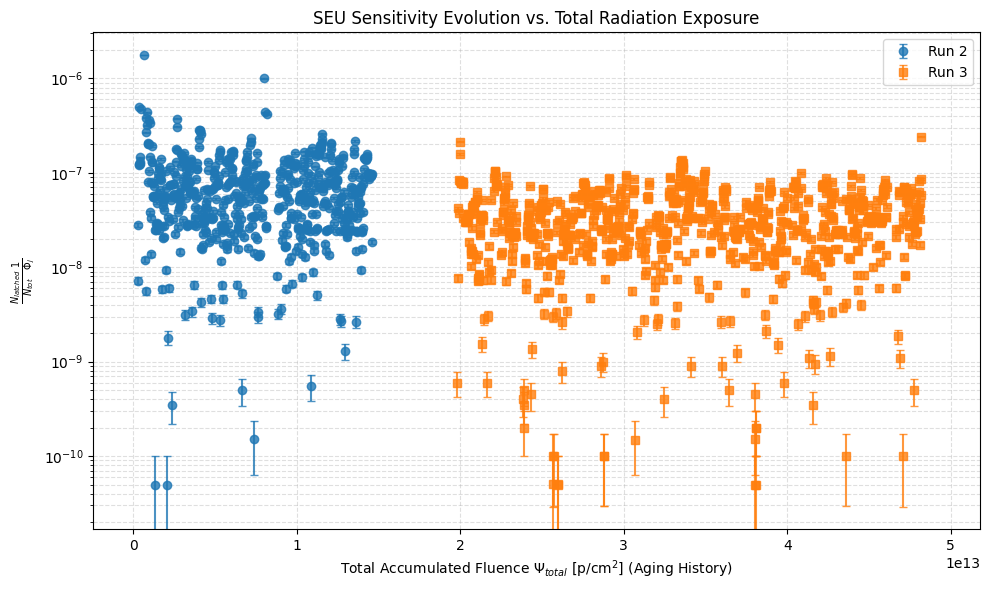

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_dual_fluence_method(df_seu, df_events_latchup, target_live_fluence_per_bin=5e9):
    """
    Calcula Sigma normalizando por Fluencia Viva, pero reportando Fluencia Total para el eje X.
    """
    # --- 1. PREPARACIÓN (Igual que antes) ---
    df = df_seu.copy().sort_index()
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index('time')

    # Generar máscara Latch-up
    df['latch_up'] = False
    if df_events_latchup is not None and not df_events_latchup.empty:
        for _, row in df_events_latchup.iterrows():
            mask = (df.index >= row['start_time']) & (df.index <= row['end_time'])
            df.loc[mask, 'latch_up'] = True
            
    # Asignar conteos (reset vs instantaneo)
    df['fails_count'] = df['fails_inst'] 

    # --- 2. LOS DOS ACUMULADORES ---
    
    # A) Acumulador Total (El Reloj de Envejecimiento)
    # Asumimos que dHEH es el incremento de fluencia en ese paso (Flux * dt)
    # Si hay huecos en los datos, cumsum respeta la historia conocida.
    df['fluence_total_step'] = df['dHEH'].fillna(0)
    df['cumulative_total_fluence'] = df['fluence_total_step'].cumsum()
    
    # B) Acumulador Vivo (El Normalizador)
    # Vivo = No Latchup AND Beam On (dHEH > 0)
    df['is_live'] = (~df['latch_up']) & (df['dHEH'] > 0)
    
    df['fluence_live_step'] = df['dHEH'] * df['is_live'].astype(int)
    df['fails_live_step']   = df['fails_count'] * df['is_live'].astype(int)
    
    df['cumulative_live_fluence'] = df['fluence_live_step'].cumsum()
    
    # --- 3. BINNING (Basado en Estadística Viva) ---
    # Usamos Live Fluence para cortar los bins para asegurar que cada punto
    # tenga suficiente estadística para calcular Sigma.
    max_live = df['cumulative_live_fluence'].max()
    if max_live == 0: return None
    
    bins = np.arange(0, max_live + target_live_fluence_per_bin, target_live_fluence_per_bin)
    df['bin_idx'] = pd.cut(df['cumulative_live_fluence'], bins=bins, labels=False)
    
    # --- 4. AGREGACIÓN ---
    grouped = df.groupby('bin_idx').agg({
        'fails_live_step': 'sum',           # Errores para el numerador
        'fluence_live_step': 'sum',         # Fluencia efectiva para el denominador
        'cumulative_total_fluence': 'mean', # <--- NUEVO EJE X (Promedio del bin)
        'cumulative_live_fluence': 'mean',  # Solo referencia
        'is_live': 'sum',
        'dt': 'sum'
    }).dropna()
    
    # --- 5. CÁLCULO DE RESULTADOS ---
    # Y-Axis: Sigma (Física correcta)
    grouped['sigma'] = grouped['fails_live_step'] / grouped['fluence_live_step']
    
    # Error Bars
    n_counts = grouped['fails_live_step']
    grouped['sigma_err'] = grouped['sigma'] * (1 / np.sqrt(n_counts.replace(0, 1)))
    
    # Metadata útil
    grouped['avg_flux_in_bin'] = grouped['fluence_live_step'] / (grouped['dt'] * (grouped['is_live']/len(df))) # Estimado

    return grouped

# --- EJECUCIÓN ---
FLUENCE_BIN = 2e10 # Ajustar según tus datos

print("Procesando Dual Fluence...")
res_2 = analyze_dual_fluence_method(fails_on_2, df_latchup_2, target_live_fluence_per_bin=FLUENCE_BIN)
res_3 = analyze_dual_fluence_method(fails_on_3, df_latchup_3, target_live_fluence_per_bin=FLUENCE_BIN)


# --- PLOTEO OBJETIVO ---
plt.figure(figsize=(10, 6))

if res_2 is not None:
    # EJE X: cumulative_total_fluence (Historia Real)
    # EJE Y: sigma (Cálculo Correcto)
    plt.errorbar(res_2['cumulative_total_fluence'], res_2['sigma'], 
                 yerr=res_2['sigma_err'], fmt='o', label='Run 2', capsize=3, alpha=0.8)

if res_3 is not None:
    plt.errorbar(res_2['cumulative_total_fluence'].iloc[-1]+res_3['cumulative_total_fluence'], res_3['sigma'], 
                 yerr=res_3['sigma_err'], fmt='s', label='Run 3', capsize=3, alpha=0.8)

plt.xlabel(r'Total Accumulated Fluence $\Psi_{total}$ [p/cm$^2$] (Aging History)')
plt.ylabel(r'$\frac{N_{latched}}{N_{tot}} \frac{1}{\Phi_j}$')
plt.title('SEU Sensitivity Evolution vs. Total Radiation Exposure')
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()
plt.tight_layout()
plt.show()

We see that its constant as it evolves in time there's no important bias or outlier seen. We proceed with the final implementation for the TMR logic.

Procesando Run 2...
Procesando Run 3...


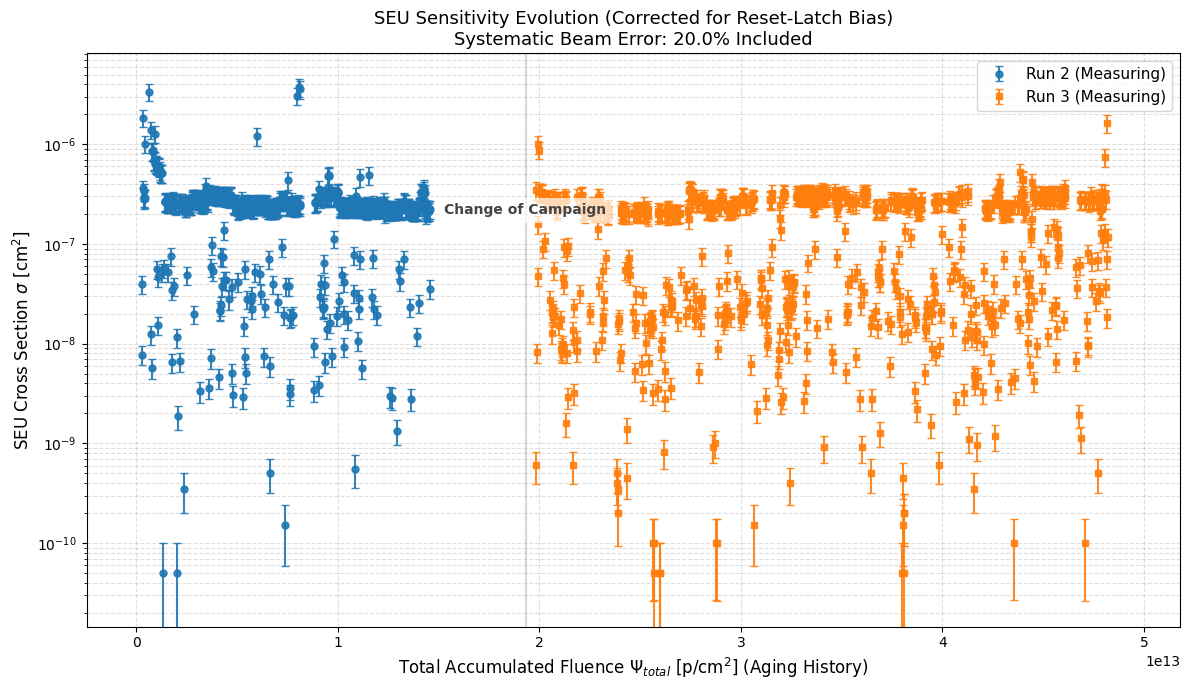

Muestra de datos corregidos (Run 2):
         occupancy  lambda_sec      flux_avg  sigma  sigma_err
bin_idx                                                       
0              0.0        -0.0  9.120944e+06   -0.0       -0.0
1              0.0        -0.0  3.140218e+08   -0.0       -0.0
2              0.0        -0.0  3.100255e+08   -0.0       -0.0
3              0.0        -0.0  3.120322e+08   -0.0       -0.0
4              0.0        -0.0  3.182332e+08   -0.0       -0.0


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def analyze_advanced_method(df_seu, df_events_latchup, 
                            reset_period_s=0.1, 
                            target_live_fluence_per_bin=5e9,
                            beam_instability=0.01):
    """
    Calcula Sigma aplicando primero la corrección de ocupancia (Reset-Latch) para obtener Lambda,
    y luego normalizando por el flujo promedio. Incluye propagación de error sistemático.
    
    Args:
        reset_period_s: El tiempo T de la ventana de reset del hardware (ej. 0.1s).
        beam_instability: Incertidumbre sistemática del haz (ej. 0.20 para 20%).
    """
    # --- 1. PREPARACIÓN ---
    df = df_seu.copy().sort_index()
    if not isinstance(df.index, pd.DatetimeIndex):
        df = df.set_index('time')

    # Máscara Latch-up
    df['latch_up'] = False
    if df_events_latchup is not None and not df_events_latchup.empty:
        for _, row in df_events_latchup.iterrows():
            mask = (df.index >= row['start_time']) & (df.index <= row['end_time'])
            df.loc[mask, 'latch_up'] = True
            
    # Asignar conteos: Asumimos fails_inst = 1 si hubo error, 0 si no
    df['fails_count'] = df['fails_inst'] 

    # --- 2. ACUMULADORES (Total vs Vivo) ---
    # Fluencia Total (Eje X - Historia)
    df['fluence_total_step'] = df['dHEH'].fillna(0)
    df['cumulative_total_fluence'] = df['fluence_total_step'].cumsum()
    
    # Fluencia Viva (Para Binning)
    df['is_live'] = (~df['latch_up']) & (df['dHEH'] > 0)
    
    df['fluence_live_step'] = df['dHEH'] * df['is_live'].astype(int)
    df['fails_live_step']   = df['fails_count'] * df['is_live'].astype(int)
    # Contamos intervalos válidos (muestras) para el denominador de ocupancia
    df['intervals_live_step'] = 1 * df['is_live'].astype(int)
    
    df['cumulative_live_fluence'] = df['fluence_live_step'].cumsum()
    
    # --- 3. BINNING ---
    max_live = df['cumulative_live_fluence'].max()
    if max_live == 0: return None
    
    bins = np.arange(0, max_live + target_live_fluence_per_bin, target_live_fluence_per_bin)
    df['bin_idx'] = pd.cut(df['cumulative_live_fluence'], bins=bins, labels=False)
    
    # --- 4. AGREGACIÓN ---
    # Sumamos todo dentro del bin
    grouped = df.groupby('bin_idx').agg({
        'fails_live_step': 'sum',           # N_latched (k)
        'intervals_live_step': 'sum',       # N_tot (n)
        'fluence_live_step': 'sum',         # Fluencia total en bin
        'dt': 'sum',                        # Tiempo total en bin
        'cumulative_total_fluence': 'mean', # Eje X
    }).dropna()
    
    # Filtro de calidad: Eliminar bins con 0 intervalos válidos
    grouped = grouped[grouped['intervals_live_step'] > 0]

    # --- 5. CÁLCULO DE FÍSICA (Correction First) ---
    
    # A) Cálculo de Ocupancia (Phi)
    # phi = N_latched / N_total_intervals
    grouped['occupancy'] = grouped['fails_live_step'] / grouped['intervals_live_step']
    
    # Clip para evitar log(0) si occupancy=1 (saturación total)
    # Usamos un techo de seguridad (ej. 0.999)
    grouped['occupancy'] = grouped['occupancy'].clip(upper=0.9999)
    
    # B) Cálculo de Lambda Corregida (Rate por segundo)
    # Formula: lambda = -ln(1 - phi) / T_reset
    # Nota: El signo menos es porque ln(0..1) es negativo.
    grouped['lambda_sec'] = -np.log(1 - grouped['occupancy']) / reset_period_s
    
    # C) Cálculo de Flujo Promedio en el Bin
    # Flux = Fluencia_viva / Tiempo_vivo
    # Estimamos Tiempo_vivo como N_intervalos * T_reset (o dt * fraction, si dt es fiable)
    # Usaremos dt sumado del bin, asumiendo que dt solo sumó partes vivas si filtramos antes, 
    # PERO 'dt' en agg sumó todo el tiempo del bin.
    # Mejor estimación: Flux = Fluence_bin / (N_intervals * reset_period_s)
    time_live_total = grouped['intervals_live_step'] * reset_period_s
    grouped['flux_avg'] = grouped['fluence_live_step'] / time_live_total
    
    # D) Cálculo de Sigma
    # Sigma = Lambda / Flux
    grouped['sigma'] = grouped['lambda_sec'] / grouped['flux_avg']
    
    # --- 6. PROPAGACIÓN DE ERRORES (Stat + Syst) ---
    
    # Error Estadístico (Poisson en conteos brutos)
    # Relativo = 1 / sqrt(N_latched)
    grouped['rel_err_stat'] = 1 / np.sqrt(grouped['fails_live_step'].replace(0, 1))
    
    # Error Sistemático (Haz)
    grouped['rel_err_syst'] = beam_instability
    
    # Error Total (Suma en Cuadratura)
    grouped['rel_err_total'] = np.sqrt(grouped['rel_err_stat']**2 + grouped['rel_err_syst']**2)
    
    # Error Absoluto Sigma
    grouped['sigma_err'] = grouped['sigma'] * grouped['rel_err_total']

    return grouped

# --- EJECUCIÓN ---
# Ajusta el RESET_PERIOD según tu hardware (ej. 0.1s, 1.0s)
RESET_PERIOD = 0.1 
FLUENCE_BIN = 2e10 
BEAM_SYST_ERR = 0.20 # 20%

print("Procesando Run 2...")
res_2 = analyze_advanced_method(fails_on_2, df_latchup_2, 
                                reset_period_s=RESET_PERIOD, 
                                target_live_fluence_per_bin=FLUENCE_BIN,
                                beam_instability=BEAM_SYST_ERR)

print("Procesando Run 3...")
res_3 = analyze_advanced_method(fails_on_3, df_latchup_3, 
                                reset_period_s=RESET_PERIOD, 
                                target_live_fluence_per_bin=FLUENCE_BIN,
                                beam_instability=BEAM_SYST_ERR)

# --- CALCULO DE OFFSET DEL GAP ---
# Asumimos que Run 3 es continuación física de Run 2
# El "Gap" es la diferencia entre donde terminó Run 2 y donde empieza Run 3
# Si los archivos tienen fluencia absoluta, usamos eso. 
# Si Run 3 empieza en 0, le sumamos el final de Run 2 + un "Blind Gap" estimado.
# Asumiré aquí que 'cumulative_total_fluence' en tus datos ya viene correcta o
# que simplemente concatenamos visualmente.
# Para garantizar visualización correcta si son independientes:
offset_run3 = res_2['cumulative_total_fluence'].iloc[-1]

# --- PLOTEO PROFESIONAL ---
plt.figure(figsize=(12, 7))

# Plot Run 2
if res_2 is not None:
    plt.errorbar(res_2['cumulative_total_fluence'], res_2['sigma'], 
                 yerr=res_2['sigma_err'], 
                 fmt='o', color='#1f77b4', label='Run 2 (Measuring)', 
                 capsize=3, alpha=0.9, markersize=5)

# Plot Run 3 (Con Offset si aplica)
if res_3 is not None:
    x_run3 = res_3['cumulative_total_fluence'] + offset_run3
    plt.errorbar(x_run3, res_3['sigma'], 
                 yerr=res_3['sigma_err'], 
                 fmt='s', color='#ff7f0e', label='Run 3 (Measuring)', 
                 capsize=3, alpha=0.9, markersize=5)
    
    # DIBUJAR EL GAP (ZONA GRIS)
    if res_2 is not None:
        gap_start = res_2['cumulative_total_fluence'].max()
        gap_end = x_run3.min()
        
        if gap_end > gap_start:
            plt.axvspan(gap_start, gap_end, color='gray', alpha=0.2, hatch='///')
            
            # Anotación centrada
            mid_x = (gap_start + gap_end) / 2
            mid_y = res_2['sigma'].median()
            plt.text(mid_x, mid_y, "Change of Campaign", 
                     ha='center', va='center', fontsize=10, 
                     color='#444444', fontweight='bold',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.xlabel(r'Total Accumulated Fluence $\Psi_{total}$ [p/cm$^2$] (Aging History)', fontsize=12)
plt.ylabel(r'SEU Cross Section $\sigma$ [cm$^2$]', fontsize=12)
plt.title(f'SEU Sensitivity Evolution (Corrected for Reset-Latch Bias)\nSystematic Beam Error: {BEAM_SYST_ERR*100}% Included', fontsize=13)
plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Mostrar resultados
if res_2 is not None:
    print("Muestra de datos corregidos (Run 2):")
    print(res_2[['occupancy', 'lambda_sec', 'flux_avg', 'sigma', 'sigma_err']].head())

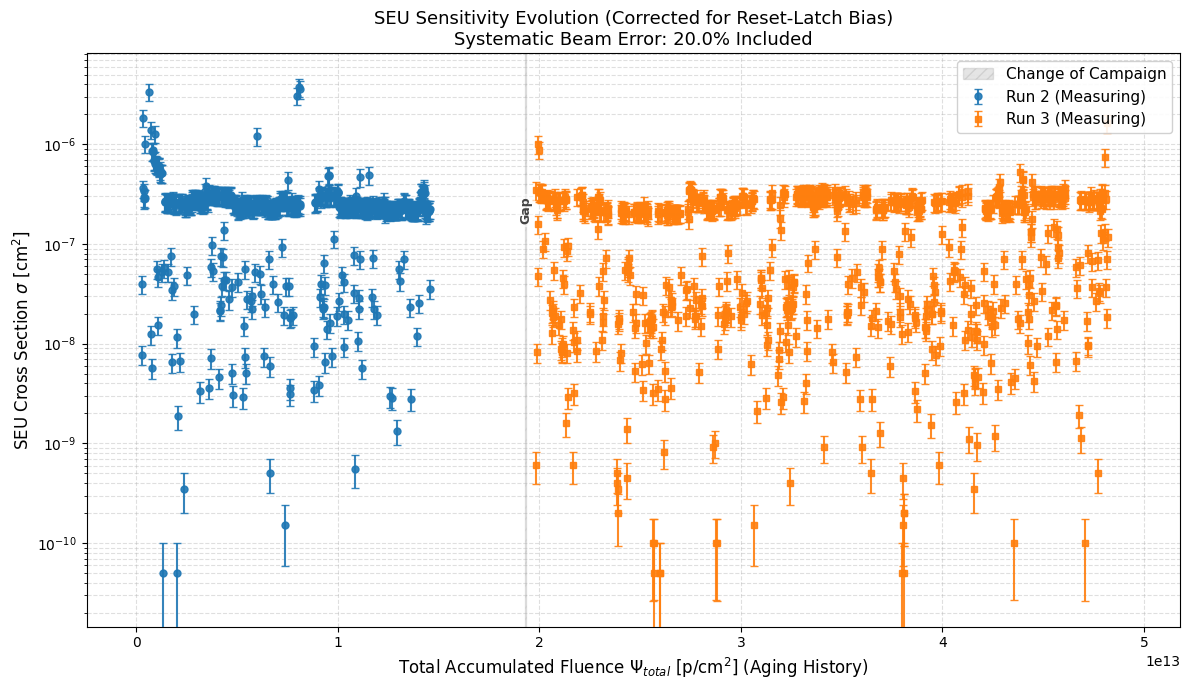

In [8]:
# --- PLOTEO PROFESIONAL CON LEYENDA COMPLETA ---
plt.figure(figsize=(12, 7))

# 1. Plot Run 2
if res_2 is not None:
    plt.errorbar(res_2['cumulative_total_fluence'], res_2['sigma'], 
                 yerr=res_2['sigma_err'], 
                 fmt='o', color='#1f77b4', label='Run 2 (Measuring)', 
                 capsize=3, alpha=0.9, markersize=5, zorder=3)

# 2. Plot Run 3 (Con Offset)
if res_3 is not None:
    x_run3 = res_3['cumulative_total_fluence'] + offset_run3
    plt.errorbar(x_run3, res_3['sigma'], 
                 yerr=res_3['sigma_err'], 
                 fmt='s', color='#ff7f0e', label='Run 3 (Measuring)', 
                 capsize=3, alpha=0.9, markersize=5, zorder=3)
    
    # 3. DIBUJAR EL GAP (ZONA GRIS) + LEGEND
    if res_2 is not None:
        gap_start = res_2['cumulative_total_fluence'].max()
        gap_end = x_run3.min()
        
        if gap_end > gap_start:
            # AQUI ESTA EL TRUCO: Agregamos 'label' al axvspan
            plt.axvspan(gap_start, gap_end, 
                        color='gray', alpha=0.2, hatch='///', 
                        label='Change of Campaign', zorder=1)
            
            # Mantenemos la anotación de texto para claridad visual en el gráfico
            mid_x = (gap_start + gap_end) / 2
            # Usamos una posición Y robusta (mediana de datos visibles)
            mid_y = res_2['sigma'].median()
            
            plt.text(mid_x, mid_y, "Gap", 
                     ha='center', va='center', fontsize=9, 
                     color='#444444', fontweight='bold', rotation=90,
                     bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=2))

# Configuración de Ejes y Títulos
plt.xlabel(r'Total Accumulated Fluence $\Psi_{total}$ [p/cm$^2$] (Aging History)', fontsize=12)
plt.ylabel(r'SEU Cross Section $\sigma$ [cm$^2$]', fontsize=12)
plt.title(f'SEU Sensitivity Evolution (Corrected for Reset-Latch Bias)\nSystematic Beam Error: {BEAM_SYST_ERR*100}% Included', fontsize=13)

plt.yscale('log')
plt.grid(True, which="both", ls="--", alpha=0.4, zorder=0)

# Generar la Leyenda (Matplotlib recogerá automáticamente el axvspan)
plt.legend(fontsize=11, loc='upper right', framealpha=0.9)

plt.tight_layout()
plt.show()

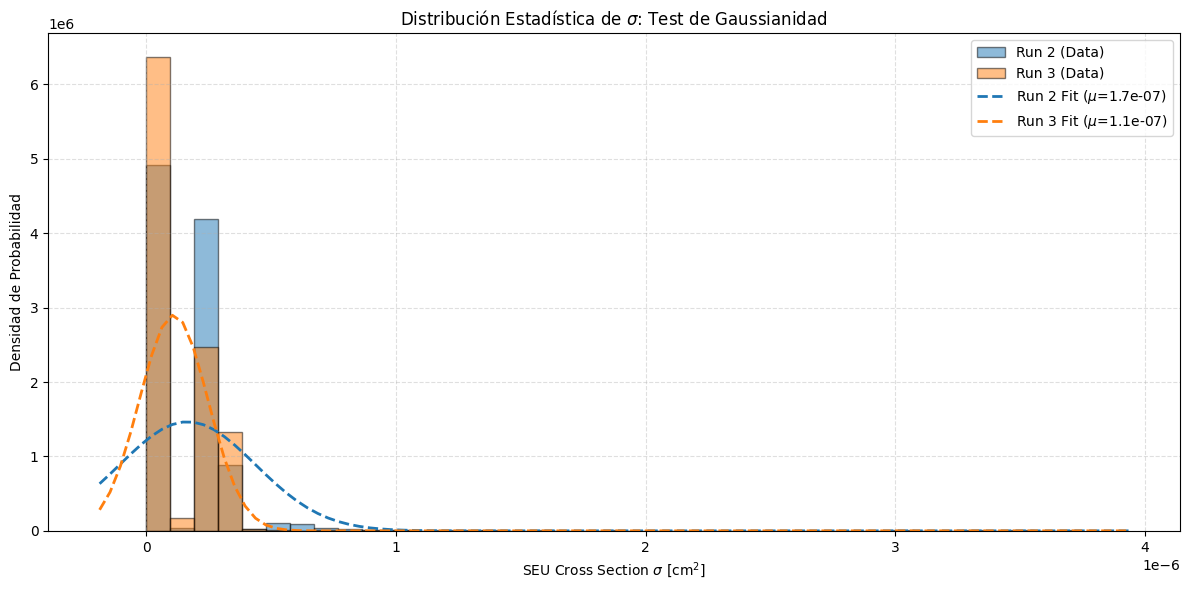

METRICA         | RUN 2           | RUN 3           | INTERPRETACIÓN
-----------------------------------------------------------------
Media (mu)      | 1.65e-07        | 1.09e-07        | ¿Deriva en sensibilidad?
Std Dev         | 2.72e-07        | 1.38e-07        | Dispersión / Ruido
Skewness        | 7.87           | 1.71           | 0 = Simétrico (Gauss)
Kurtosis        | 89.09           | 10.23           | 0 = Colas Normales


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, kurtosis

def plot_sigma_histogram(res_2, res_3, bins=30):
    """
    Grafica histogramas comparativos de Sigma con ajuste Gaussiano
    y reporta estadísticas descriptivas.
    """
    # 1. Extraer datos válidos
    # Filtramos ceros o infinitos si existieran por seguridad
    s2 = res_2['sigma'].replace([np.inf, -np.inf], np.nan).dropna()
    s3 = res_3['sigma'].replace([np.inf, -np.inf], np.nan).dropna()
    
    # OPCIONAL: Filtrar outliers extremos para que el histograma no se rompa
    # (ej. quitamos el piso de ruido de 10^-10 si ensucia la vista)
    # s2 = s2[s2 > 1e-9]
    # s3 = s3[s3 > 1e-9]

    # 2. Configurar figura
    plt.figure(figsize=(12, 6))
    
    # Definir bins comunes para comparabilidad
    global_min = min(s2.min(), s3.min())
    global_max = max(s2.max(), s3.max())
    # Usamos bins lineales para testear Gaussianidad visualmente
    common_bins = np.linspace(global_min, global_max, bins)
    
    # 3. Graficar Histogramas (Density=True para comparar forma)
    # Run 2
    plt.hist(s2, bins=common_bins, density=True, 
             alpha=0.5, color='#1f77b4', edgecolor='black', label='Run 2 (Data)')
    
    # Run 3
    plt.hist(s3, bins=common_bins, density=True, 
             alpha=0.5, color='#ff7f0e', edgecolor='black', label='Run 3 (Data)')

    # 4. Ajuste Gaussiano (Fit)
    # Calculamos mu y std reales de los datos
    mu2, std2 = norm.fit(s2)
    mu3, std3 = norm.fit(s3)
    
    # Generar eje X suave para las curvas
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    
    # Plotear curvas
    p2 = norm.pdf(x, mu2, std2)
    plt.plot(x, p2, color='#1f77b4', linestyle='--', linewidth=2, label=f'Run 2 Fit ($\mu$={mu2:.1e})')
    
    p3 = norm.pdf(x, mu3, std3)
    plt.plot(x, p3, color='#ff7f0e', linestyle='--', linewidth=2, label=f'Run 3 Fit ($\mu$={mu3:.1e})')

    # 5. Estética
    plt.xlabel(r'SEU Cross Section $\sigma$ [cm$^2$]')
    plt.ylabel('Densidad de Probabilidad')
    plt.title('Distribución Estadística de $\sigma$: Test de Gaussianidad')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.4)
    
    # Formato científico en eje X
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    
    plt.tight_layout()
    plt.show()
    
    # 6. Reporte Estadístico Numérico
    print(f"{'METRICA':<15} | {'RUN 2':<15} | {'RUN 3':<15} | {'INTERPRETACIÓN'}")
    print("-" * 65)
    print(f"{'Media (mu)':<15} | {mu2:.2e}        | {mu3:.2e}        | {'¿Deriva en sensibilidad?'}")
    print(f"{'Std Dev':<15} | {std2:.2e}        | {std3:.2e}        | {'Dispersión / Ruido'}")
    print(f"{'Skewness':<15} | {skew(s2):.2f}           | {skew(s3):.2f}           | {'0 = Simétrico (Gauss)'}")
    print(f"{'Kurtosis':<15} | {kurtosis(s2):.2f}           | {kurtosis(s3):.2f}           | {'0 = Colas Normales'}")

# Ejecutar
plot_sigma_histogram(res_2, res_3, bins=40)

Analizando Run 2...
=== Análisis de Outliers: Run 2 ===
Total Puntos: 966
Outliers Detectados: 17 (1.8%)
Límite Superior (IQR): 6.28e-07


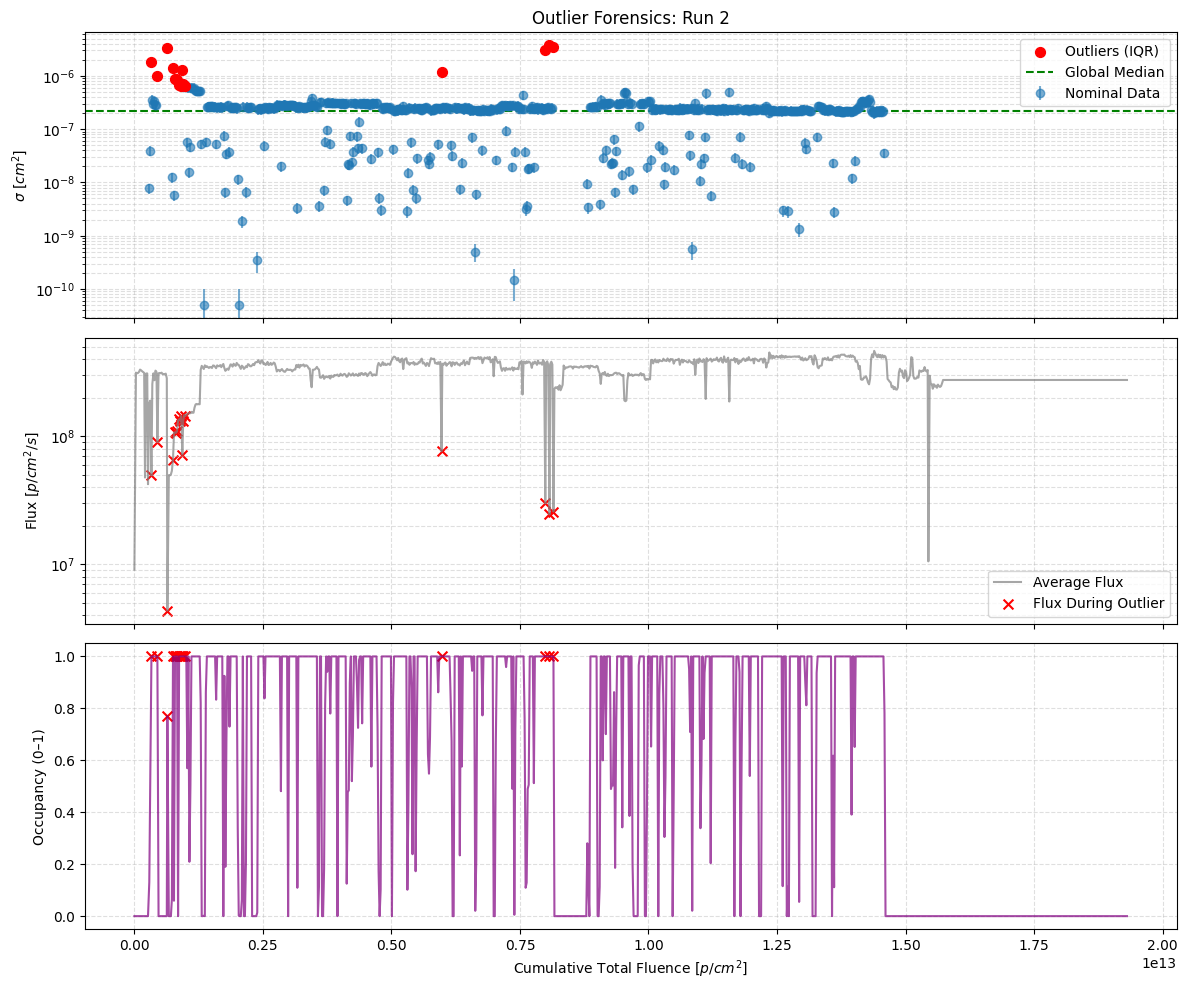

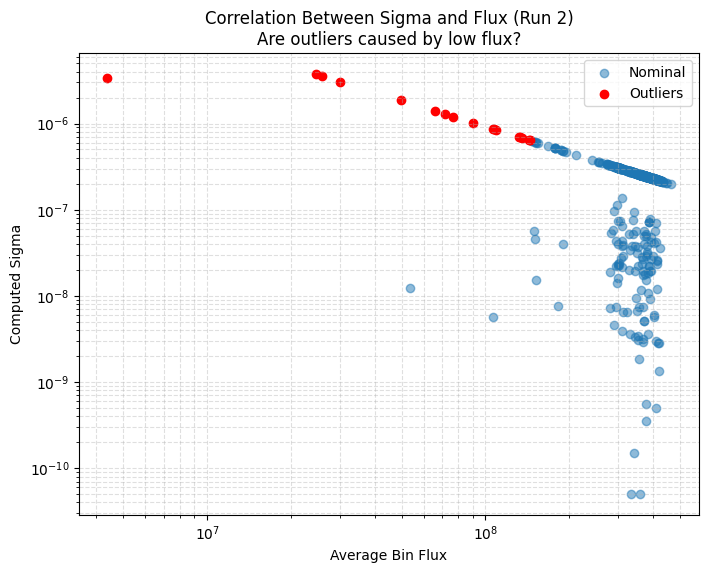


Analizando Run 3...
=== Análisis de Outliers: Run 3 ===
Total Puntos: 1487
Outliers Detectados: 4 (0.3%)
Límite Superior (IQR): 5.85e-07


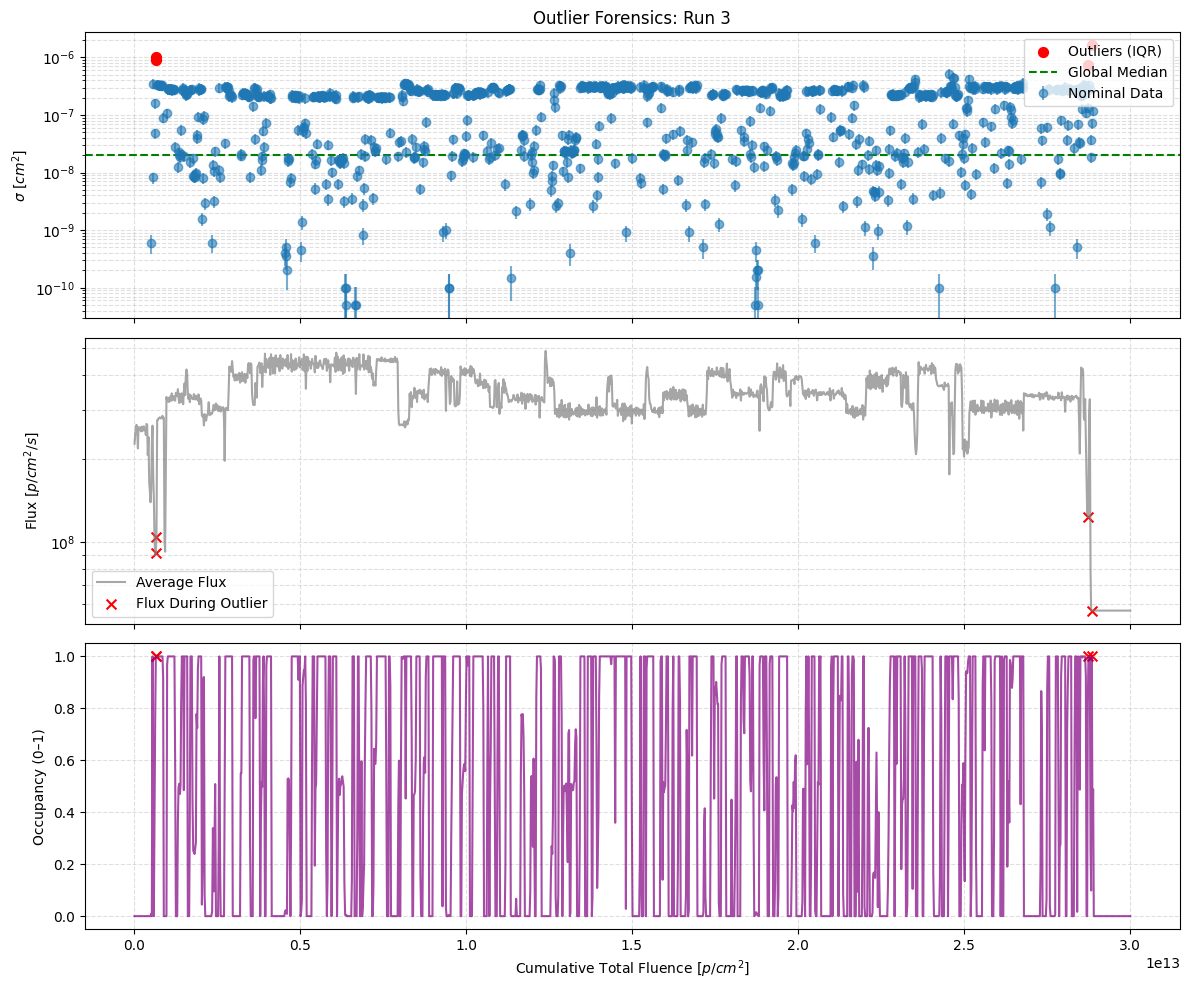

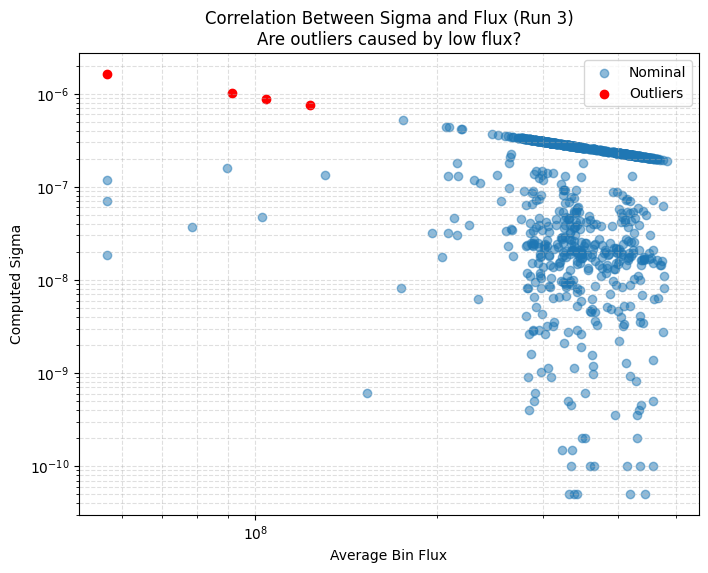

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def analyze_and_plot_outliers(grouped_df, run_name="Run 2"):
    """
    Identifica outliers usando IQR, los plotea contra el haz y la corriente
    para diagnóstico forense.
    """
    df = grouped_df.copy()
    
    # 1. DETECCIÓN DE OUTLIERS (MÉTODO IQR)
    Q1 = df['sigma'].quantile(0.25)
    Q3 = df['sigma'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Usamos 1.5 para detección estándar (o 3.0 para extremos)
    upper_bound = Q3 + 1.5 * IQR
    lower_bound = Q1 - 1.5 * IQR
    
    outliers = df[(df['sigma'] > upper_bound) | (df['sigma'] < lower_bound)]
    valid_data = df[(df['sigma'] <= upper_bound) & (df['sigma'] >= lower_bound)]
    
    print(f"=== Análisis de Outliers: {run_name} ===")
    print(f"Total Puntos: {len(df)}")
    print(f"Outliers Detectados: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
    print(f"Límite Superior (IQR): {upper_bound:.2e}")
    
    # 2. PLOT DIAGNÓSTICO (3 Paneles)
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    
    # PANEL A: Sigma (Cross Section)
    axes[0].errorbar(
        valid_data['cumulative_total_fluence'], valid_data['sigma'], 
        yerr=valid_data['sigma_err'], fmt='o', color='#1f77b4', 
        alpha=0.6, label='Nominal Data'
    )
    
    axes[0].scatter(
        outliers['cumulative_total_fluence'], outliers['sigma'], 
        color='red', s=50, zorder=5, label='Outliers (IQR)'
    )
    
    axes[0].axhline(
        df['sigma'].median(), color='green', linestyle='--',
        label='Global Median'
    )
    axes[0].set_ylabel(r'$\sigma$ [$cm^2$]')
    axes[0].set_yscale('log')
    axes[0].legend(loc='upper right')
    axes[0].set_title(f'Outlier Forensics: {run_name}')
    axes[0].grid(True, which="both", ls="--", alpha=0.4)

    # PANEL B: Flux (Intensidad del Haz)
    # Queremos ver si el outlier coincide con inestabilidad del haz
    axes[1].plot(
        df['cumulative_total_fluence'], df['flux_avg'], 
        color='gray', alpha=0.7, label='Average Flux'
    )
    
    # Marcamos donde están los outliers en el panel del haz
    axes[1].scatter(
        outliers['cumulative_total_fluence'], outliers['flux_avg'], 
        color='red', marker='x', s=50, label='Flux During Outlier'
    )
    
    axes[1].set_ylabel(r'Flux [$p/cm^2/s$]')
    axes[1].set_yscale('log')
    axes[1].legend()
    axes[1].grid(True, which="both", ls="--", alpha=0.4)
    
    # PANEL C: Occupancy (Saturación)
    # Queremos ver si el outlier coincide con una ráfaga de errores
    axes[2].plot(
        df['cumulative_total_fluence'], df['occupancy'], 
        color='purple', alpha=0.7, label='Occupancy'
    )
    
    axes[2].scatter(
        outliers['cumulative_total_fluence'], outliers['occupancy'], 
        color='red', marker='x', s=50
    )
    
    axes[2].set_ylabel('Occupancy (0–1)')
    axes[2].set_xlabel(r'Cumulative Total Fluence [$p/cm^2$]')
    axes[2].grid(True, ls="--", alpha=0.4)
    
    plt.tight_layout()
    plt.show()
    
    # 3. CORRELACIÓN SIGMA vs FLUX (El "Smoking Gun")
    # Si los puntos rojos están a la izquierda (bajo flux), es un artefacto matemático.
    plt.figure(figsize=(8, 6))
    plt.scatter(valid_data['flux_avg'], valid_data['sigma'], alpha=0.5, label='Nominal')
    plt.scatter(outliers['flux_avg'], outliers['sigma'], color='red', label='Outliers')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Average Bin Flux')
    plt.ylabel('Computed Sigma')
    plt.title(
        f'Correlation Between Sigma and Flux ({run_name})\n'
        'Are outliers caused by low flux?'
    )
    plt.legend()
    plt.grid(True, which="both", ls="--", alpha=0.4)
    plt.show()

    return valid_data  # Retorna el DF limpio por si quieres usarlo

# --- EJECUCIÓN ---
print("Analizando Run 2...")
df_clean_2 = analyze_and_plot_outliers(res_2, "Run 2")

print("\nAnalizando Run 3...")
df_clean_3 = analyze_and_plot_outliers(res_3, "Run 3")


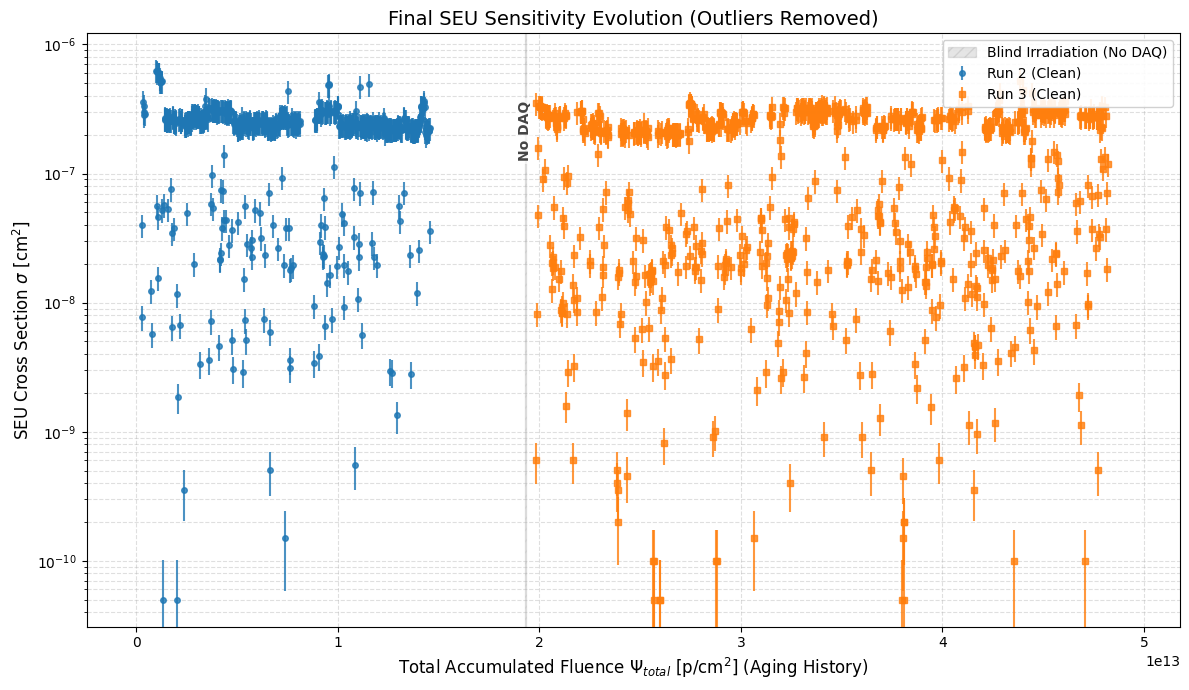

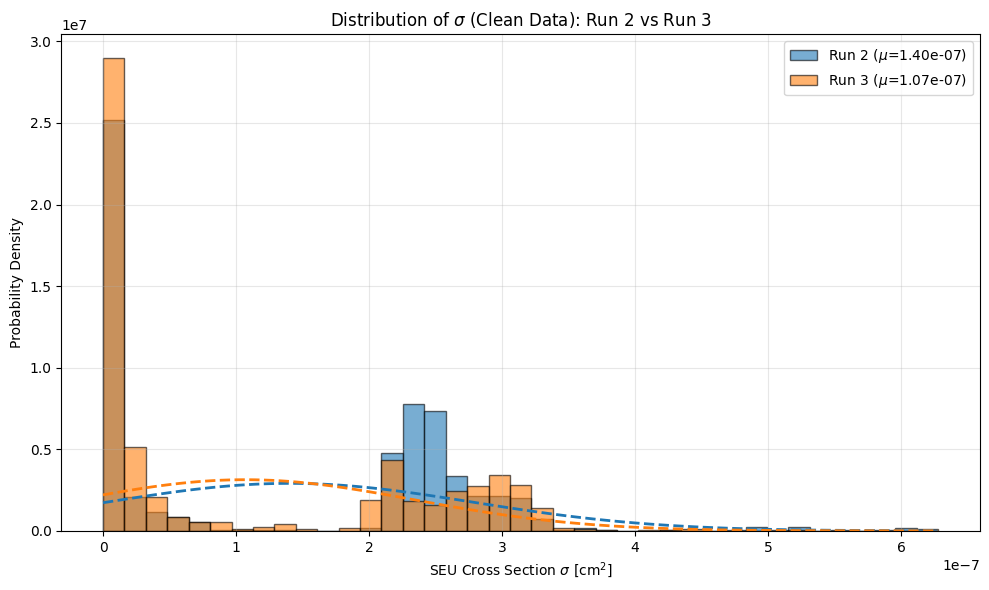

METRIC          | RUN 2 (CLEAN)   | RUN 3 (CLEAN)   | CHANGE (%)
-----------------------------------------------------------------
Mean            | 1.40e-07        | 1.07e-07        | -23.9%
Median          | 2.15e-07        | 2.00e-08        | -90.7%
Std Dev         | 1.37e-07        | 1.27e-07        | -
Points (N)      | 949             | 1483            | -


In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

def plot_final_clean_results(clean_2, clean_3):
    """
    Generates the final analysis plots using the cleaned datasets:
    1. Evolution of Sigma vs Total Fluence (with Gap)
    2. Comparative Histograms with Gaussian Fits
    3. Statistical Summary Table
    """
    
    # --- 1. PREPARE DATA & OFFSET ---
    # Calculate offset for Run 3 so it starts after Run 2
    offset = clean_2['cumulative_total_fluence'].max()
    x_run3 = clean_3['cumulative_total_fluence'] + offset
    
    # --- 2. PLOT 1: EVOLUTION OF SIGMA ---
    plt.figure(figsize=(12, 7))
    
    # Run 2 (Clean)
    plt.errorbar(clean_2['cumulative_total_fluence'], clean_2['sigma'], 
                 yerr=clean_2['sigma_err'], fmt='o', color='#1f77b4', 
                 label='Run 2 (Clean)', alpha=0.8, markersize=4, zorder=3)
    
    # Run 3 (Clean + Offset)
    plt.errorbar(x_run3, clean_3['sigma'], 
                 yerr=clean_3['sigma_err'], fmt='s', color='#ff7f0e', 
                 label='Run 3 (Clean)', alpha=0.8, markersize=4, zorder=3)

    # Blind Gap Visualization
    gap_start = clean_2['cumulative_total_fluence'].max()
    gap_end = x_run3.min()
    
    if gap_end > gap_start:
        plt.axvspan(gap_start, gap_end, color='gray', alpha=0.2, hatch='///', 
                    label='Blind Irradiation (No DAQ)', zorder=1)
        
        # Text annotation in the middle of the gap
        mid_x = (gap_start + gap_end) / 2
        mid_y = clean_2['sigma'].median()
        plt.text(mid_x, mid_y, "No DAQ", 
                 ha='center', va='center', fontsize=10, 
                 color='#444444', fontweight='bold', rotation=90,
                 bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=2))

    # Formatting
    plt.yscale('log')
    plt.xlabel(r'Total Accumulated Fluence $\Psi_{total}$ [p/cm$^2$] (Aging History)', fontsize=12)
    plt.ylabel(r'SEU Cross Section $\sigma$ [cm$^2$]', fontsize=12)
    plt.title('Final SEU Sensitivity Evolution (Outliers Removed)', fontsize=14)
    plt.grid(True, which="both", ls="--", alpha=0.4, zorder=0)
    plt.legend(loc='upper right', framealpha=0.9)
    plt.tight_layout()
    plt.show()

    # --- 3. PLOT 2: COMPARATIVE HISTOGRAMS ---
    plt.figure(figsize=(10, 6))
    
    # Define common bins for direct comparison
    all_data = np.concatenate([clean_2['sigma'], clean_3['sigma']])
    bins = np.linspace(all_data.min(), all_data.max(), 40)
    
    # Histogram Run 2
    mu2, std2 = norm.fit(clean_2['sigma'])
    plt.hist(clean_2['sigma'], bins=bins, density=True, alpha=0.6, 
             color='#1f77b4', edgecolor='black', label=f'Run 2 ($\mu$={mu2:.2e})')
    
    # Histogram Run 3
    mu3, std3 = norm.fit(clean_3['sigma'])
    plt.hist(clean_3['sigma'], bins=bins, density=True, alpha=0.6, 
             color='#ff7f0e', edgecolor='black', label=f'Run 3 ($\mu$={mu3:.2e})')
    
    # Gaussian Fits
    x_fit = np.linspace(bins.min(), bins.max(), 100)
    plt.plot(x_fit, norm.pdf(x_fit, mu2, std2), color='#1f77b4', linestyle='--', linewidth=2)
    plt.plot(x_fit, norm.pdf(x_fit, mu3, std3), color='#ff7f0e', linestyle='--', linewidth=2)
    
    # Formatting
    plt.xlabel(r'SEU Cross Section $\sigma$ [cm$^2$]')
    plt.ylabel('Probability Density')
    plt.title('Distribution of $\sigma$ (Clean Data): Run 2 vs Run 3')
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    # --- 4. PRINT SUMMARY STATISTICS ---
    print(f"{'METRIC':<15} | {'RUN 2 (CLEAN)':<15} | {'RUN 3 (CLEAN)':<15} | {'CHANGE (%)'}")
    print("-" * 65)
    mean2, mean3 = clean_2['sigma'].mean(), clean_3['sigma'].mean()
    med2, med3 = clean_2['sigma'].median(), clean_3['sigma'].median()
    
    diff_mean = ((mean3 - mean2) / mean2) * 100
    diff_med = ((med3 - med2) / med2) * 100
    
    print(f"{'Mean':<15} | {mean2:.2e}        | {mean3:.2e}        | {diff_mean:+.1f}%")
    print(f"{'Median':<15} | {med2:.2e}        | {med3:.2e}        | {diff_med:+.1f}%")
    print(f"{'Std Dev':<15} | {clean_2['sigma'].std():.2e}        | {clean_3['sigma'].std():.2e}        | -")
    print(f"{'Points (N)':<15} | {len(clean_2):<15} | {len(clean_3):<15} | -")

# Execute using the cleaned dataframes from the previous cell
plot_final_clean_results(df_clean_2, df_clean_3)

=== RESULTADOS DE TEST ESTADÍSTICO (Nivel de confianza 95%) ===
N_Run2 = 949, N_Run3 = 1483

[1] Kolmogorov-Smirnov Test (Forma General)
    Estadístico KS: 0.1871 (Distancia máxima entre ECDFs)
    P-value:        3.4577e-18
    >> RESULTADO: RECHAZAMOS H0. Las distribuciones son ESTADÍSTICAMENTE DIFERENTES.

[2] Mann-Whitney U Test (Tendencia Central)
    Estadístico U:  758555.0
    P-value:        8.7525e-04
    >> RESULTADO: RECHAZAMOS H0. Las medianas difieren significativamente.


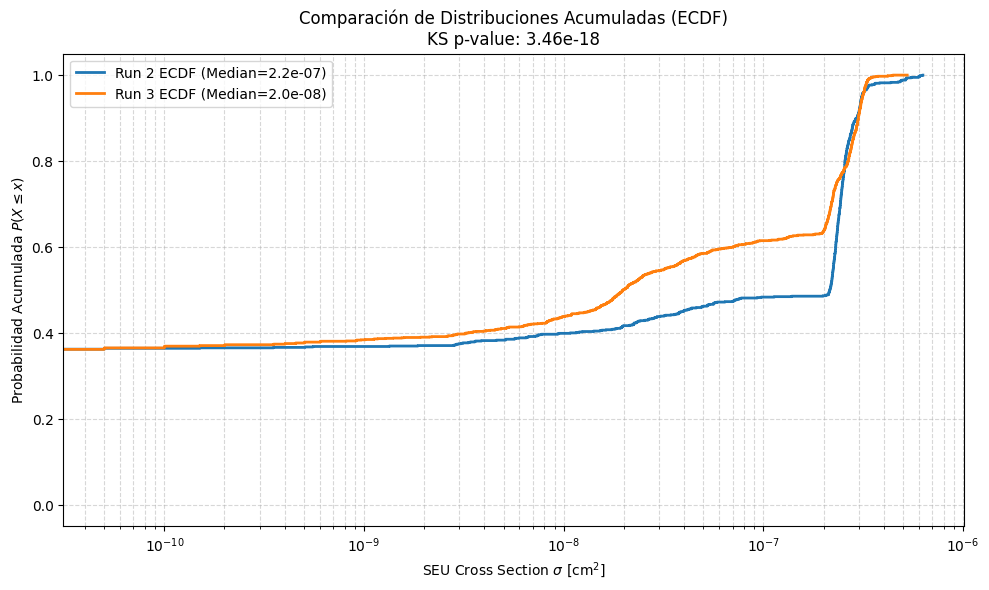

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def perform_statistical_comparison(clean_2, clean_3, alpha=0.05):
    """
    Realiza tests estadísticos no paramétricos para comparar las distribuciones
    de Sigma entre Run 2 y Run 3.
    
    Tests incluidos:
    1. Kolmogorov-Smirnov (2-sample): ¿Son la misma distribución?
    2. Mann-Whitney U: ¿Tienen la misma tendencia central (mediana)?
    """
    
    s2 = clean_2['sigma'].values
    s3 = clean_3['sigma'].values
    
    print("=== RESULTADOS DE TEST ESTADÍSTICO (Nivel de confianza 95%) ===")
    print(f"N_Run2 = {len(s2)}, N_Run3 = {len(s3)}")
    
    # --- 1. Test de Kolmogorov-Smirnov (KS) ---
    # H0: Las dos muestras vienen de la misma distribución continua.
    # Es sensible a diferencias en forma, ubicación y dispersión.
    ks_stat, ks_p = stats.ks_2samp(s2, s3)
    
    print(f"\n[1] Kolmogorov-Smirnov Test (Forma General)")
    print(f"    Estadístico KS: {ks_stat:.4f} (Distancia máxima entre ECDFs)")
    print(f"    P-value:        {ks_p:.4e}")
    
    if ks_p < alpha:
        print("    >> RESULTADO: RECHAZAMOS H0. Las distribuciones son ESTADÍSTICAMENTE DIFERENTES.")
    else:
        print("    >> RESULTADO: No se puede rechazar H0. Podrían ser la misma distribución.")

    # --- 2. Test de Mann-Whitney U ---
    # H0: Las distribuciones son iguales.
    # H1: Una distribución es estocásticamente mayor que la otra (diferencia de medianas).
    u_stat, mw_p = stats.mannwhitneyu(s2, s3, alternative='two-sided')
    
    print(f"\n[2] Mann-Whitney U Test (Tendencia Central)")
    print(f"    Estadístico U:  {u_stat:.1f}")
    print(f"    P-value:        {mw_p:.4e}")
    
    if mw_p < alpha:
        print("    >> RESULTADO: RECHAZAMOS H0. Las medianas difieren significativamente.")
    else:
        print("    >> RESULTADO: No hay evidencia de cambio en la tendencia central.")

    # --- 3. Visualización: ECDF (Empirical Cumulative Distribution Function) ---
    # El test KS mide la distancia vertical máxima entre estas dos curvas.
    
    def ecdf(data):
        """Helper para calcular x, y para ECDF"""
        x = np.sort(data)
        n = len(data)
        y = np.arange(1, n+1) / n
        return x, y

    x2, y2 = ecdf(s2)
    x3, y3 = ecdf(s3)
    
    plt.figure(figsize=(10, 6))
    plt.step(x2, y2, label=f'Run 2 ECDF (Median={np.median(s2):.1e})', linewidth=2)
    plt.step(x3, y3, label=f'Run 3 ECDF (Median={np.median(s3):.1e})', linewidth=2)
    
    # Dibujar la línea de máxima diferencia (KS statistic visualize)
    # Esto es ilustrativo, encontrar el punto exacto requiere argmax
    plt.title(f'Comparación de Distribuciones Acumuladas (ECDF)\nKS p-value: {ks_p:.2e}')
    plt.xlabel(r'SEU Cross Section $\sigma$ [cm$^2$]')
    plt.ylabel('Probabilidad Acumulada $P(X \leq x)$')
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.legend()
    plt.xscale('log') # Log scale ayuda a ver las diferencias en órdenes de magnitud
    plt.tight_layout()
    plt.show()

# Ejecutar análisis
perform_statistical_comparison(df_clean_2, df_clean_3)

## Presentation of value

=== FINAL REPORTED VALUES (DATASHEET) ===
Typical Sensitivity (Median Run 3): 2.00e-08 cm^2/bit
Worst-Case Nominal (Median Run 2):  2.15e-07 cm^2/bit
DESIGN LIMIT (95% Conf. Run 2):     3.11e-07 cm^2/bit
---------------------------------------


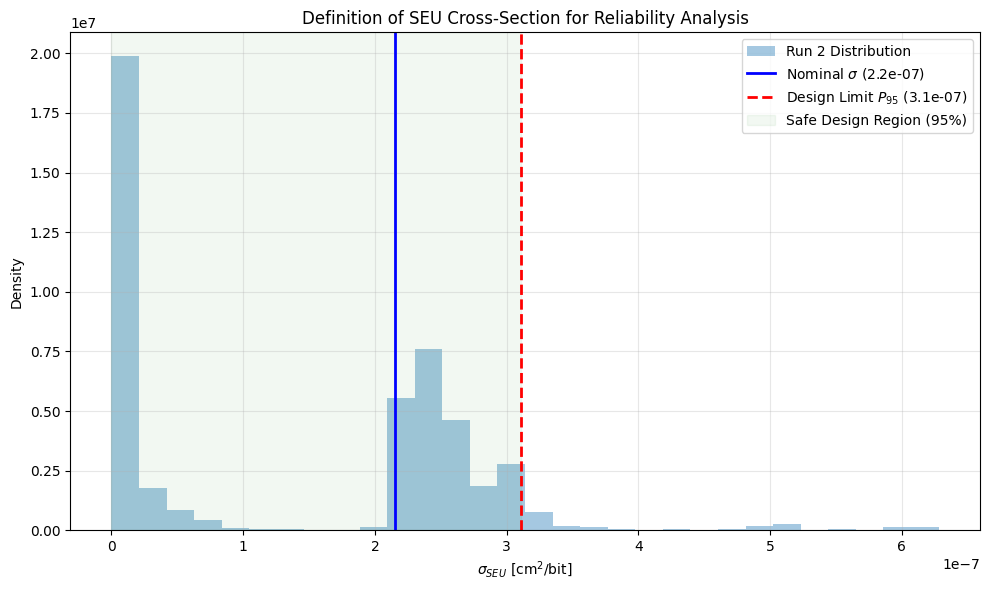

In [13]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_design_sigma(clean_2, clean_3):
    """
    Calcula los valores de diseño basados en estadística no paramétrica (Percentiles).
    Define el 'Worst-Case Design Value' usando el P95 del Run 2.
    """
    # 1. Extraer datos
    s2 = clean_2['sigma'].values
    s3 = clean_3['sigma'].values
    
    # 2. Calcular Estadísticas Robustas (Percentiles)
    # Run 2 (Worst Case Scenario)
    p50_r2 = np.percentile(s2, 50)  # Mediana (Nominal)
    p95_r2 = np.percentile(s2, 95)  # Límite Superior (Diseño)
    
    # Run 3 (Best Case)
    p50_r3 = np.percentile(s3, 50)

    print("=== FINAL REPORTED VALUES (DATASHEET) ===")
    print(f"Typical Sensitivity (Median Run 3): {p50_r3:.2e} cm^2/bit")
    print(f"Worst-Case Nominal (Median Run 2):  {p50_r2:.2e} cm^2/bit")
    print(f"DESIGN LIMIT (95% Conf. Run 2):     {p95_r2:.2e} cm^2/bit")
    print("---------------------------------------")
    
    # 3. Visualización de la Decisión
    plt.figure(figsize=(10, 6))
    
    # Histograma de fondo (Run 2)
    plt.hist(s2, bins=30, density=True, alpha=0.4, color='#1f77b4', label='Run 2 Distribution')
    
    # Líneas de Reporte
    plt.axvline(p50_r2, color='blue', linestyle='-', linewidth=2, 
                label=f'Nominal $\sigma$ ({p50_r2:.1e})')
    
    plt.axvline(p95_r2, color='red', linestyle='--', linewidth=2, 
                label=f'Design Limit $P_{{95}}$ ({p95_r2:.1e})')
    
    # Zona de Seguridad
    plt.axvspan(0, p95_r2, color='green', alpha=0.05, label='Safe Design Region (95%)')

    plt.title('Definition of SEU Cross-Section for Reliability Analysis')
    plt.xlabel(r'$\sigma_{SEU}$ [cm$^2$/bit]')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    plt.tight_layout()
    plt.show()
    
    return p50_r2, p95_r2

# Ejecutar con los datos limpios anteriores
sigma_nom, sigma_max = calculate_design_sigma(df_clean_2, df_clean_3)